# 1. Lectura de Dades

In [51]:

import pandas as pd


df_train = pd.read_csv('diamonds-train.csv')
df_test = pd.read_csv('diamonds-test.csv')


print(f"Nombre de mostres d'entrenament: {df_train.shape[0]}")
print(f"Nombre de mostres de test: {df_test.shape[0]}")


df_train.head()


Nombre de mostres d'entrenament: 44000
Nombre de mostres de test: 9940


,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.53,Very Good,D,VS2,63.2,56.0,5.10,5.15,3.24,1601
1,2,0.32,Premium,H,VS2,62.4,58.0,4.36,4.33,2.71,648
2,3,0.76,Ideal,I,SI1,61.8,57.0,5.89,5.83,3.62,2399
3,4,1.01,Good,H,VS2,60.8,61.0,6.43,6.50,3.93,5229
4,5,0.73,Ideal,I,VS1,62.1,54.0,5.77,5.80,3.59,2167


# 2. Preprocessament de dades


In [2]:

invalid_dimensions = df_train[(df_train['x'] <= 0) | (df_train['y'] <= 0) | (df_train['z'] <= 0)]
print(f"Dimensions no físiques (x, y, z <= 0): {invalid_dimensions.shape[0]} files")


invalid_depth = df_train[(df_train['depth'] < 43) | (df_train['depth'] > 79)]
print(f"Valors de depth fora del rang 43-79: {invalid_depth.shape[0]} files")

invalid_table = df_train[(df_train['table'] < 43) | (df_train['table'] > 95)]
print(f"Valors de table fora del rang 43-95: {invalid_table.shape[0]} files")

df_train['depth_calc'] = 2 * df_train['z'] / (df_train['x'] + df_train['y'])

inconsistent_depth = df_train[abs(df_train['depth_calc'] - df_train['depth'] / 100) > 0.05]
print(f"Incoherència entre depth i dimensions: {inconsistent_depth.shape[0]} files")

Dimensions no físiques (x, y, z <= 0): 16 files
Valors de depth fora del rang 43-79: 0 files
Valors de table fora del rang 43-95: 0 files
Incoherència entre depth i dimensions: 31 files


- Identificacio de outliers


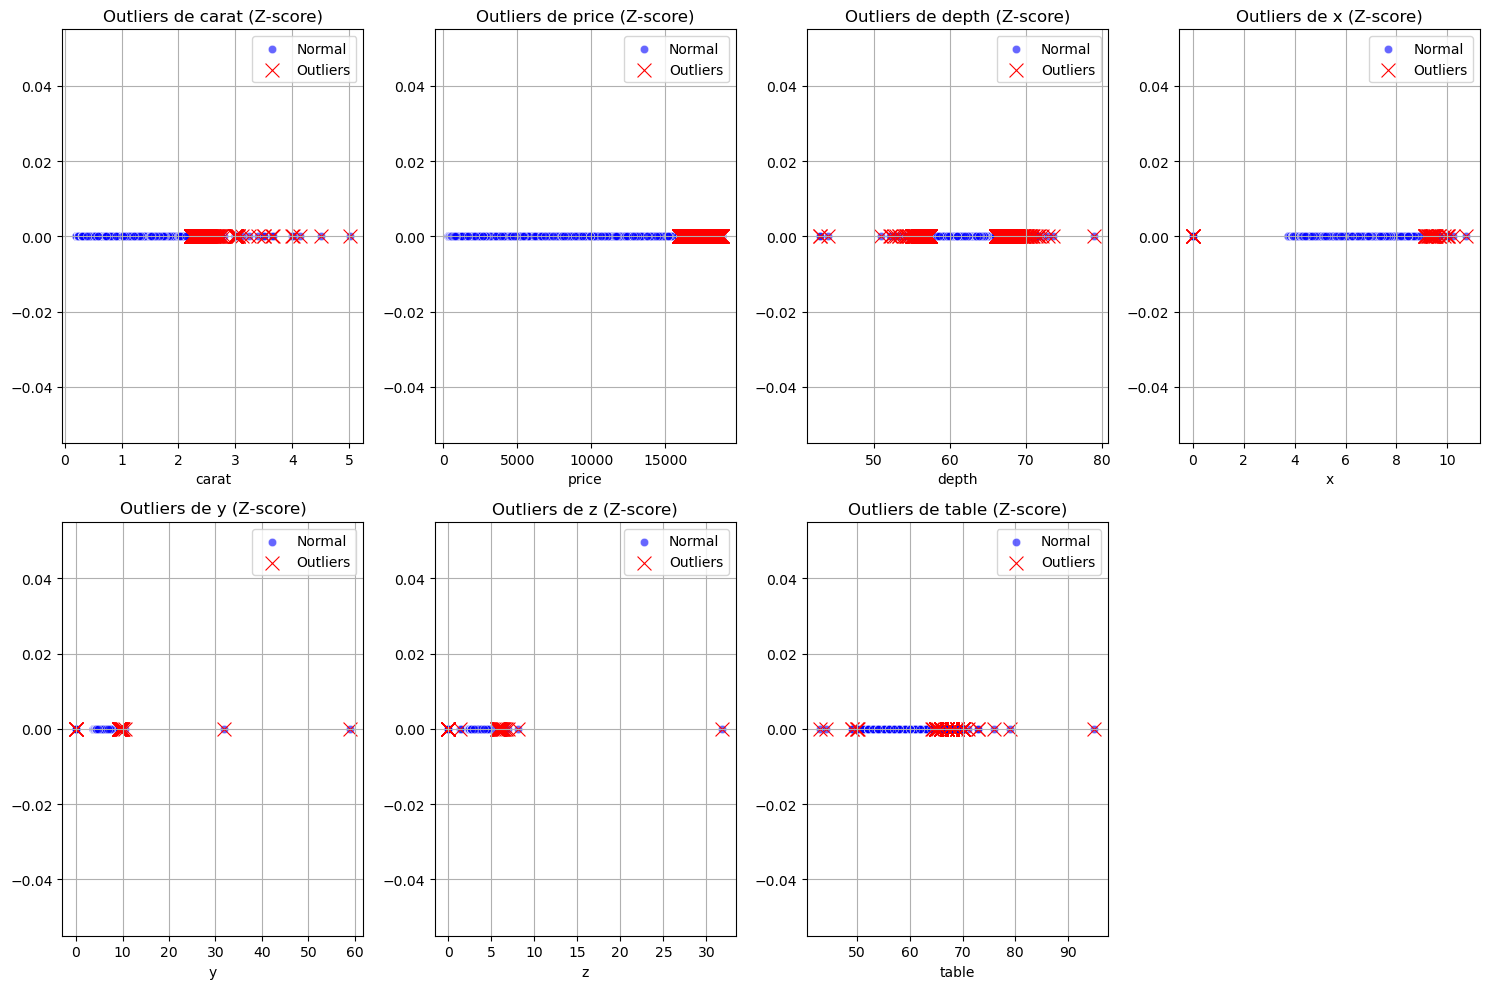

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Atributs numèrics a analitzar
num_cols = ['carat', 'price', 'depth', 'x', 'y', 'z', 'table']

# Crearem una figura per mostrar tots els scatter plots
plt.figure(figsize=(15, 10))

# Crear un gràfic per cada atribut
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 4, i)  # Creem una subgràfica (2 files, 4 columnes)
    
    # Scatter plot de l'atribut
    sns.scatterplot(x=df_train[col], y=[0] * len(df_train), color='blue', alpha=0.6, label='Normal')
    
    # Afegeix els outliers en vermell
    outliers = df_train[(df_train[f'{col}_zscore'] > 3) | (df_train[f'{col}_zscore'] < -3)]
    sns.scatterplot(x=outliers[col], y=[0] * len(outliers), color='red', label='Outliers', s=100, marker='x')
    
    plt.title(f"Outliers de {col} (Z-score)")
    plt.xlabel(col)
    plt.ylabel('')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()




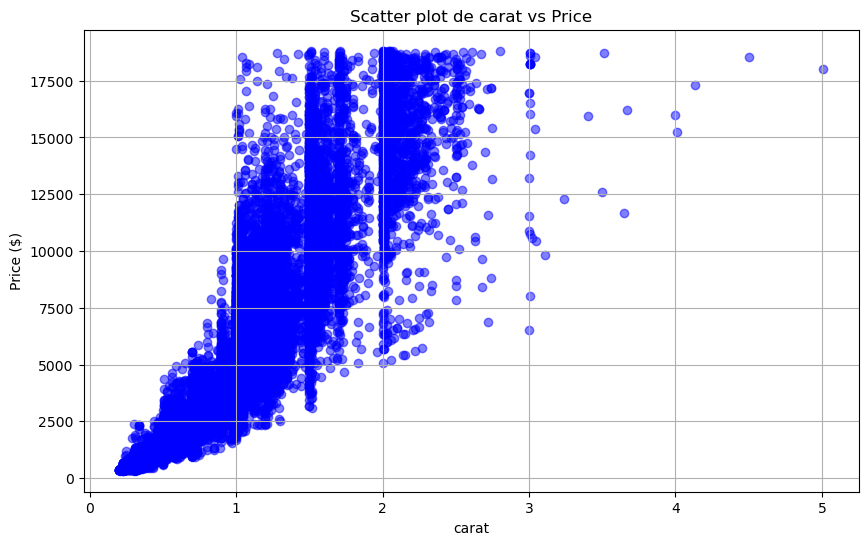

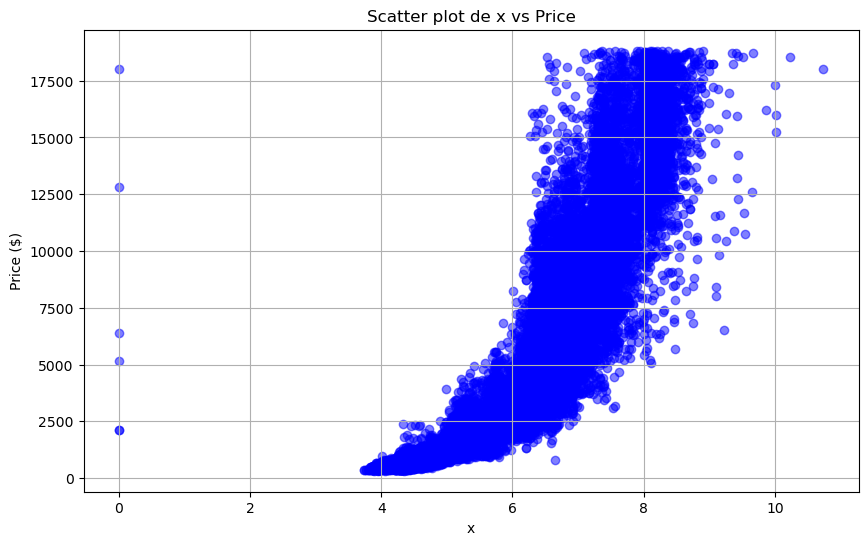

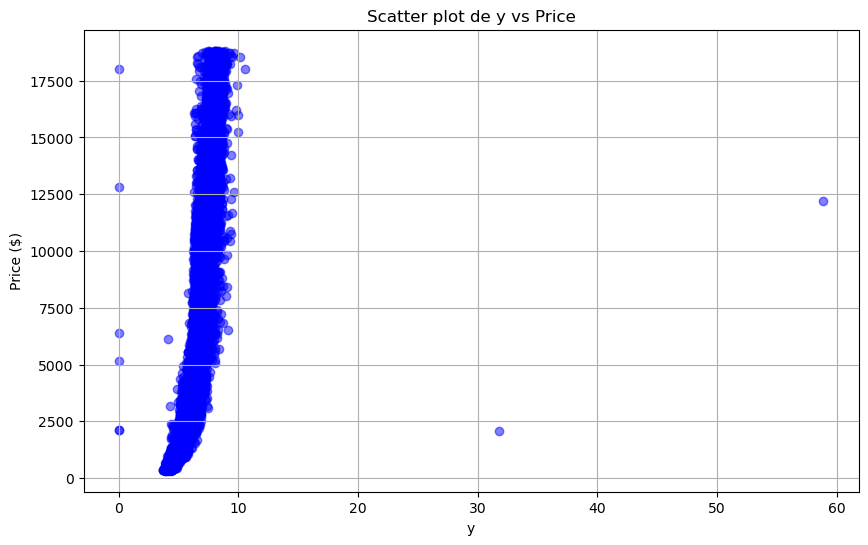

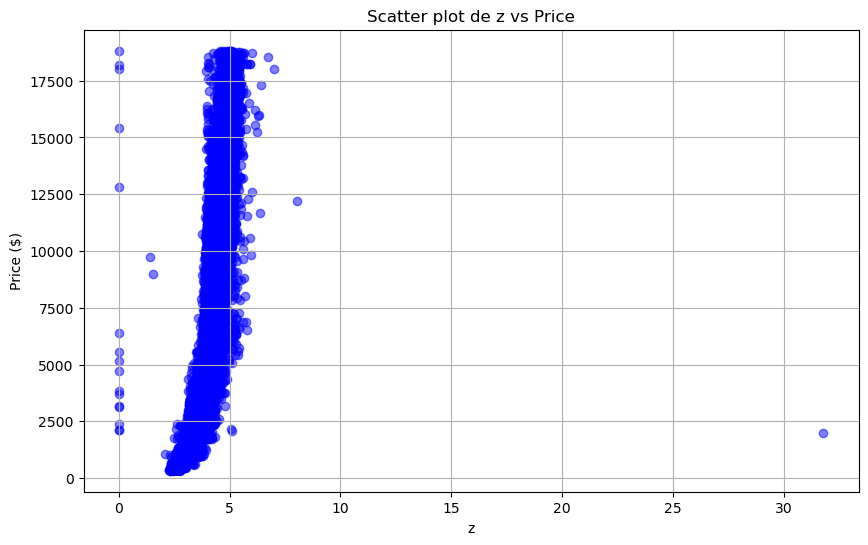

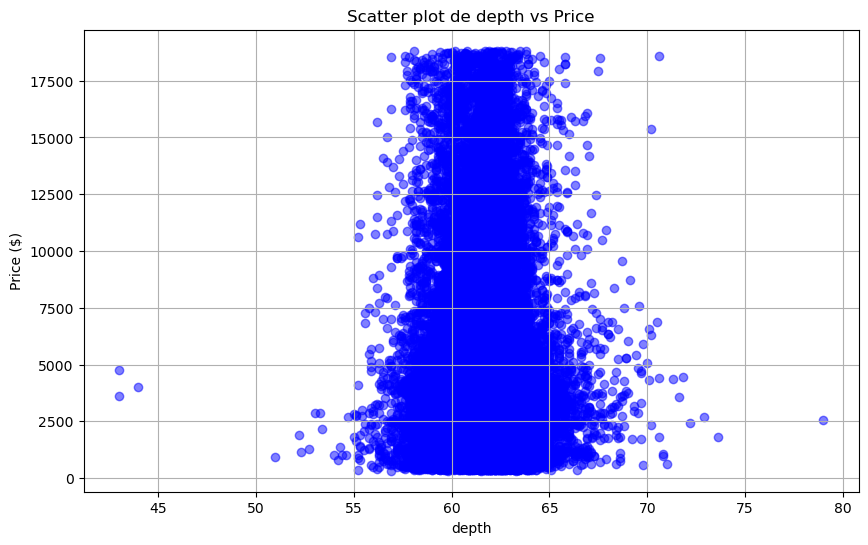

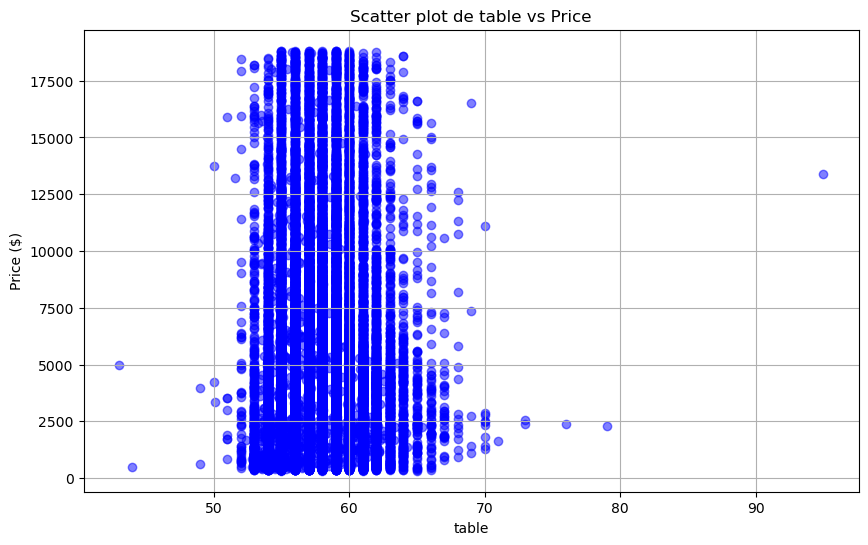

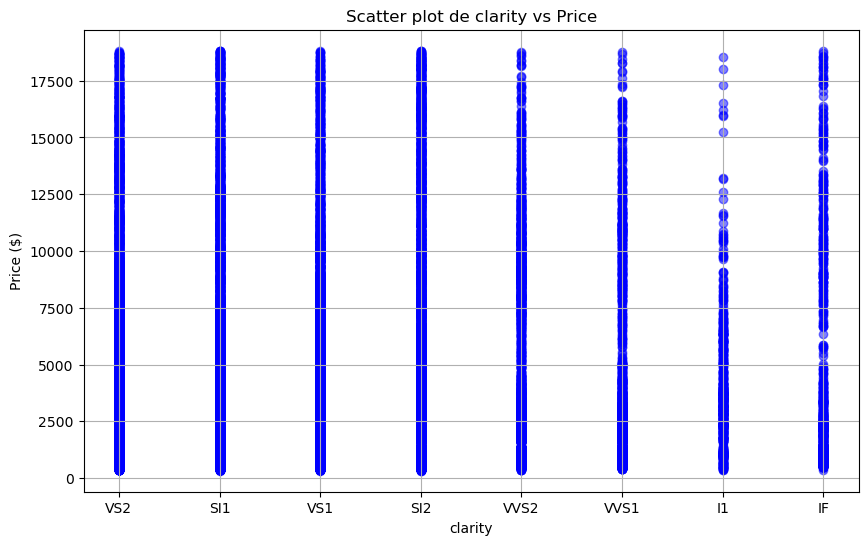

In [20]:
import matplotlib.pyplot as plt

# Atributs numèrics que volem visualitzar contra el preu
num_cols = ['carat', 'x', 'y', 'z', 'depth', 'table']

# Dibuixem el scatter plot de cada atribut vs preu
for col in num_cols:
    plt.figure(figsize=(10, 6))
    plt.scatter(df_train[col], df_train['price'], color='blue', alpha=0.5)
    plt.title(f"Scatter plot de {col} vs Price")
    plt.xlabel(col)
    plt.ylabel('Price ($)')
    plt.grid(True)
    plt.show()


Els outliers de dades que no son numeriques no els considerem perquè no podem comparar text amb valors numerics.

In [18]:
from scipy.stats import zscore

# Atributs numèrics a analitzar
num_cols = ['carat', 'price', 'depth', 'x', 'y', 'z', 'table']

# Calcular el Z-score per cada atribut
outliers_zscore_info = []

# Calcular el Z-score per cada columna numèrica
for col in num_cols:
    df_train[f'{col}_zscore'] = zscore(df_train[col])  # Afegim el Z-score a les dades
    
    # Identificar els outliers: Z-score > 3 o Z-score < -3
    outliers = df_train[(df_train[f'{col}_zscore'] > 3) | (df_train[f'{col}_zscore'] < -3)]
    
    # Afegir la informació dels outliers a la llista
    for idx, row in outliers.iterrows():
        outliers_zscore_info.append({
            'id': row['id'],
            'attribute': col,
            'value': row[col],
            'zscore': row[f'{col}_zscore'],
            'reason': f"Outlier per Z-score: valor amb Z-score = {row[f'{col}_zscore']:.2f}"
        })

# Convertim la llista a un DataFrame per facilitar la visualització
outliers_zscore_df = pd.DataFrame(outliers_zscore_info)

# Mostrar la taula amb outliers
outliers_zscore_df.head()


,id,attribute,value,zscore,reason
0,79,carat,2.36,3.297895,Outlier per Z-score: valor amb Z-score = 3.30
1,292,carat,2.26,3.086775,Outlier per Z-score: valor amb Z-score = 3.09
2,302,carat,2.32,3.213447,Outlier per Z-score: valor amb Z-score = 3.21
3,344,carat,2.57,3.741245,Outlier per Z-score: valor amb Z-score = 3.74
4,499,carat,2.51,3.614573,Outlier per Z-score: valor amb Z-score = 3.61


**Que fem amb els outliers (eliminar, substituir...) PER FER ENCARA

In [40]:
cut_mapping = {
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Premium': 4,
    'Ideal': 5
}
color_mapping = {
    'J': 1,
    'I': 2,
    'H': 3,
    'G': 4,
    'F': 5,
    'E': 6,
    'D': 7
}
clarity_mapping = {
    'I1': 1,
    'SI2': 2,
    'SI1': 3,
    'VS2': 4,
    'VS1': 5,
    'VVS2': 6,
    'VVS1': 7,
    'IF': 8
}
df_train_num = df_train.copy()
df_test_num = df_train.copy()

df_train_num['cut'] = df_train['cut'].map(cut_mapping)
df_train_num['color'] = df_train['color'].map(color_mapping)
df_train_num['clarity'] = df_train['clarity'].map(clarity_mapping)

df_test_num['cut'] = df_test['cut'].map(cut_mapping)
df_test_num['color'] = df_test['color'].map(color_mapping)
df_test_num['clarity'] = df_test['clarity'].map(clarity_mapping)

print(df_train_num.head())


   id  carat  cut  color  clarity  depth  table     x     y     z  price
0   1   0.53    3      7        4   63.2   56.0  5.10  5.15  3.24   1601
1   2   0.32    4      3        4   62.4   58.0  4.36  4.33  2.71    648
2   3   0.76    5      2        3   61.8   57.0  5.89  5.83  3.62   2399
3   4   1.01    2      3        4   60.8   61.0  6.43  6.50  3.93   5229
4   5   0.73    5      2        5   62.1   54.0  5.77  5.80  3.59   2167


In [54]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Dataset net i amb high_price creat
df_train_std = df_train.copy()
df_test_std = df_test.copy()

# Columnes numèriques que vols estandarditzar (excloent x, y, z)
cols_to_standardize = ['carat', 'depth', 'table']

# Crear scaler
scaler = StandardScaler()

# Fit & transform només sobre train
df_train_std[cols_to_standardize] = scaler.fit_transform(df_train_std[cols_to_standardize])

# Transform sobre test (amb el mateix scaler)
df_test_std[cols_to_standardize] = scaler.transform(df_test_std[cols_to_standardize])

# Guardar la mitjana i desviació en una variable
standardization_params = pd.DataFrame({
    'mean': scaler.mean_,
    'std': scaler.scale_
}, index=cols_to_standardize)

# Mostrar la taula de paràmetres
print(standardization_params)


            mean       std
carat   0.797900  0.473666
depth  61.750986  1.430550
table  57.449593  2.232601


In [56]:
# Trobar el mínim i màxim global de les tres columnes x, y, z
min_vals_xyz = df_train[['x', 'y', 'z']].min().min()
max_vals_xyz = df_train[['x', 'y', 'z']].max().max()

# Funció d'escalat a [-1, 1]
scale_to_minus1_1 = lambda col: 2 * (col - min_vals_xyz) / (max_vals_xyz - min_vals_xyz) - 1

# Aplicar al train i guardar en nova variable
df_train_scaled_xyz = df_train[['x', 'y', 'z']].apply(scale_to_minus1_1)

# Aplicar al test amb els mateixos paràmetres
df_test_scaled_xyz = df_test[['x', 'y', 'z']].apply(scale_to_minus1_1)

# Mostrar resultats
print(df_train_scaled_xyz.head())
print(df_test_scaled_xyz.head())


          x         y         z
0 -0.826825 -0.825127 -0.889983
1 -0.851952 -0.852971 -0.907980
2 -0.800000 -0.802037 -0.877080
3 -0.781664 -0.779287 -0.866553
4 -0.804075 -0.803056 -0.878098
          x         y         z
0 -0.777929 -0.776570 -0.860781
1 -0.804754 -0.802037 -0.882513
2 -0.719185 -0.721902 -0.835654
3 -0.859423 -0.857046 -0.912733
4 -0.822750 -0.824109 -0.889983


In [57]:
import numpy as np

# Fer una còpia per treballar amb dades noves
df_train_aug = df_train.copy()
df_test_aug = df_test.copy()

# Calcular el logaritme natural del preu
df_train_aug['log_price'] = np.log(df_train_aug['price'])
df_test_aug['log_price'] = np.log(df_test_aug['price'])

# Trobar mínim i màxim del log_price només al train
log_min = df_train_aug['log_price'].min()
log_max = df_train_aug['log_price'].max()

# Funció per escalar entre 0.1 i 0.9
def scale_log_price(series, min_val, max_val):
    return 0.1 + 0.8 * (series - min_val) / (max_val - min_val)

# Escalar log_price a log_price_scaled
df_train_aug['log_price_scaled'] = scale_log_price(df_train_aug['log_price'], log_min, log_max)
df_test_aug['log_price_scaled'] = scale_log_price(df_test_aug['log_price'], log_min, log_max)

# Afegir columna binària high_price
df_train_aug['high_price'] = (df_train_aug['price'] >= 2500).astype(int)
df_test_aug['high_price'] = (df_test_aug['price'] >= 2500).astype(int)

# Comprovació ràpida
print(df_train_aug[['price', 'log_price', 'log_price_scaled', 'high_price']].head())
print(df_test_aug[['price', 'log_price', 'log_price_scaled', 'high_price']].head())


   price  log_price  log_price_scaled  high_price
0   1601   7.378384          0.413928           0
1    648   6.473891          0.235513           0
2   2399   7.782807          0.493702           0
3   5229   8.561975          0.647397           1
4   2167   7.681099          0.473640           0
   price  log_price  log_price_scaled  high_price
0   8282   9.021840          0.738107           1
1   2196   7.694393          0.476262           0
2  16731   9.725019          0.876813           1
3    760   6.633318          0.266960           0
4   1715   7.447168          0.427496           0


Llindar per preu alt (Q3): $5315.25


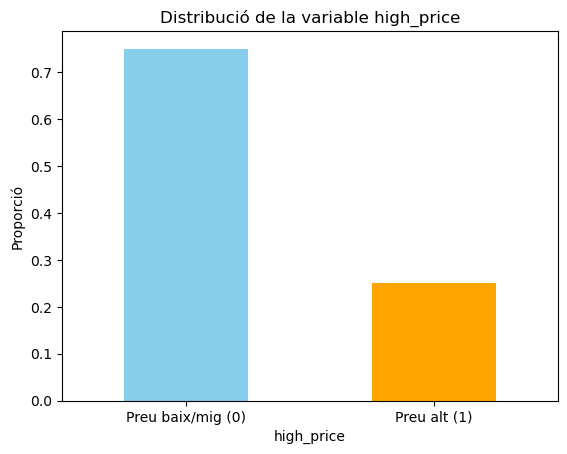

In [53]:

# Calculem el llindar de preu alt com el percentil 75
q3_price = df_train['price'].quantile(0.75)
print(f"Llindar per preu alt (Q3): ${q3_price:.2f}")

# Creem la nova variable binària
df_train['high_price'] = (df_train['price'] >= q3_price).astype(int)

# Distribució de la nova classe
df_train['high_price'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'orange'])
plt.xticks([0, 1], ['Preu baix/mig (0)', 'Preu alt (1)'], rotation=0)
plt.title("Distribució de la variable high_price")
plt.ylabel("Proporció")
plt.show()
